In [1]:
import graspy
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\dfran\Miniconda3\envs\ndd_5\lib\

In [2]:
from graspy.simulations import sbm

n_communities = [50, 50, 50]
p = [[0.5, 0.1, 0.05],
     [0.1, 0.4, 0.15],
     [0.05, 0.15, 0.3],]

np.random.seed(2)
A = sbm(n_communities, p)
from graspy.embed import AdjacencySpectralEmbed

ase = AdjacencySpectralEmbed()
X = ase.fit_transform(A)

In [3]:
import itertools
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In [13]:
def plot_ellipse(
    X,
    Y_,
    means,
    covariances,
    ax,
    j,
    k,
    colors,
    lab_dict=None,
    ind_to_lab=None,
    alpha=0.7,
    palette="Set1",
    
):
    
    for i, (mean, covar, color) in enumerate(zip(means, covariances, colors)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        if lab_dict and ind_to_lab:
            # Plot the scatter
            sns.scatterplot(X[Y_ == i, j], X[Y_ == i, k], ax=ax, label=ind_to_lab[i], color = colors[i])
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi
            ell = mpl.patches.Ellipse(
                [mean[j], mean[k]], v[0], v[1], 180.0 + angle, color=colors[i]
            )
        else:
            if not np.any(Y_ == i):
                continue
            sns.scatterplot(
                X[Y_ == i, j], X[Y_ == i, k], ax=ax, label="Block {}".format(i), color = colors[i]
            )
            # Plot an ellipse to show the Gaussian component
            angle = np.arctan(u[1] / u[0])
            angle = 180.0 * angle / np.pi
            ell = mpl.patches.Ellipse(
                [mean[j], mean[k]], v[0], v[1], 180.0 + angle, color=colors[i]
            )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(alpha)
        ax.add_artist(ell)
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_ylabel(k), ax.set_xlabel(k)


def pairplot_with_gmm(
    X,
    gmm,
    labels=None,
    title=None,
    context="talk",
    font_scale=1,
    alpha=0.7,
    palette="Set1",
):

    sns.despine(left=True)
    
    colors = sns.color_palette(palette)
   
    # Handle X
    if not isinstance(X, (list, np.ndarray)):
        msg = "X must be array-like, not {}.".format(type(X))
        raise TypeError(msg)

    # Handle labels
    if labels is not None:
        if not isinstance(labels, (list, np.ndarray)):
            msg = "Y must be array-like or list, not {}.".format(type(labels))
            raise TypeError(msg)
        elif X.shape[0] != len(labels):
            msg = "Expected length {}, but got length {} instead for Y.".format(
                X.shape[0], len(labels)
            )
            raise ValueError(msg)
    # Handle gmm
    if gmm is None:
        msg = "You must input a sklearn.mixture.GaussianMixture"
        raise TypeError(msg)
    # get relevant features from the gmm model
    Y_, means, covariances = gmm.predict(X), gmm.means_, gmm.covariances_
    # plot only a scatter plot with only two feature columns
    lab_dict, ind_to_lab = {}, {}
    if labels:
        set_labs = sorted(set(labels))
        counter = 0
        for lab in set_labs:
            lab_dict[lab] = counter
            ind_to_lab[counter] = lab
            counter += 1
    
        Y_ = np.asarray([lab_dict[labels[i]] for i in range(len(labels))])
         
    colors = dict(zip(np.unique(Y_), colors))                
    with sns.plotting_context(context=context, font_scale=font_scale):
        if X.shape[1] == 2:
            pairplot, axes = plt.subplots(1, 1, figsize=(12, 12))
            plot_ellipse(
                X,
                Y_,
                means,
                covariances,
                axes,
                0,
                1,
                colors,
                lab_dict,
                ind_to_lab,
                palette=palette,
            )
            axes.set_ylabel("Dim " + str(0))
            axes.set_xlabel("Dim " + str(1))
            axes.label_outer()
            axes.spines["right"].set_visible(False)
            axes.spines["top"].set_visible(False)
            if title:
                pairplot.suptitle(title)
            else:
                pairplot.suptitle(
                    "Fit a Gaussian mixture using "
                    + str(means.shape[0])
                    + " components"
                )
            plt.subplots_adjust(right=0.8)
            return pairplot
        # for more than two features compared
        pairplot, axes = plt.subplots(X.shape[1], X.shape[1], figsize=(12, 12))
        for k in range(X.shape[1]):
            for j in range(X.shape[1]):
                if k == j:
                    for t in range(X.shape[1]):
                        sns.distplot(X[Y_ == t, k], kde=True, ax=axes[k, k], color=colors[t])
                    axes[k, j].set_xticks([]), axes[k, j].set_yticks([])
                    axes[k, j].set_ylabel(None)
                    axes[k, j].set_ylabel(j), axes[k, j].set_xlabel(k)
                else:
                    plot_ellipse(
                        X,
                        Y_,
                        means,
                        covariances,
                        axes[k, j],
                        j,
                        k,
                        colors,
                        lab_dict,
                        ind_to_lab,
                        palette=palette,
                    )
        for i in range(X.shape[1]):
            for j in range(X.shape[1]):
                axes[i, j].set_ylabel("Dim " + str(i))
                axes[i, j].set_xlabel("Dim " + str(j))
        if title:
            pairplot.suptitle(title)
        else:
            pairplot.suptitle(
                "Fit a Gaussian mixture using " + str(means.shape[0]) + " components"
            )
        handles, labels = [], []
        for ax in axes.flat:
            ax.label_outer()
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.legend().remove()
            handles_, labels_ = ax.get_legend_handles_labels()
            handles += handles_
            labels += labels_

        pairplot.legend(
            handles[: means.shape[0]], labels[: means.shape[0]], loc="upper right"
        )
    return pairplot


[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[ 0.30330271 -0.27920086]
[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[0.55487238 0.45045656]
[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[ 0.47203248 -0.34552969]


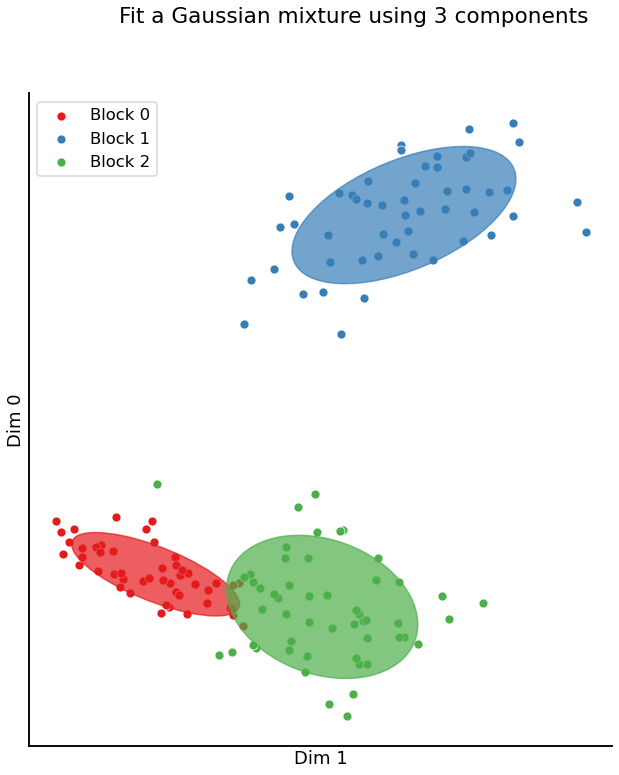

<Figure size 432x288 with 0 Axes>

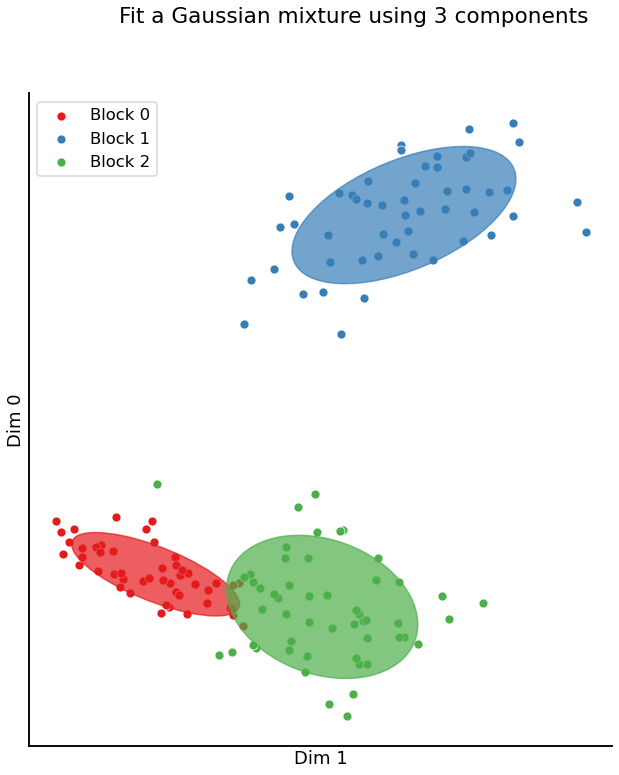

In [16]:
from sklearn.mixture import GaussianMixture
labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])
pairplot_with_gmm(X[:,:2], gmm)

[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[ 0.30330271 -0.27920086]
[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[0.55487238 0.45045656]
[[ 0.30330271 -0.27920086]
 [ 0.55487238  0.45045656]
 [ 0.47203248 -0.34552969]]
[ 0.47203248 -0.34552969]


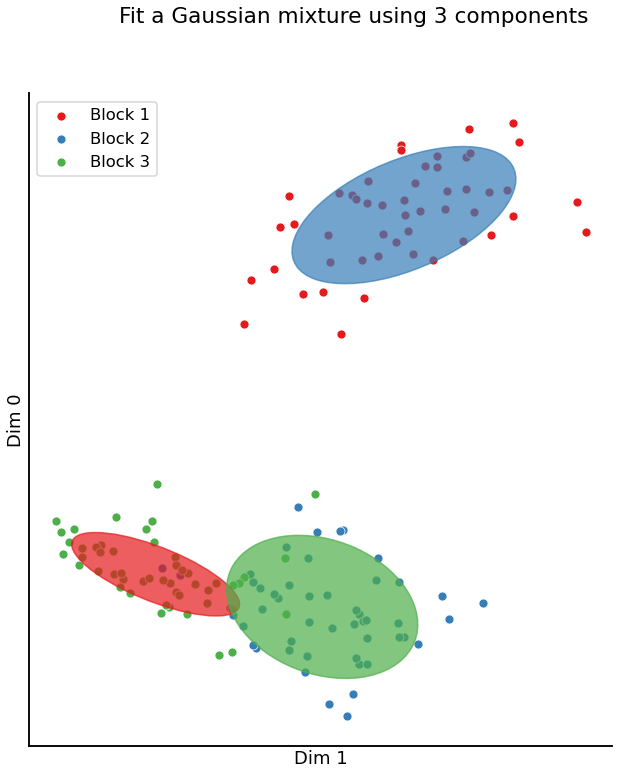

<Figure size 432x288 with 0 Axes>

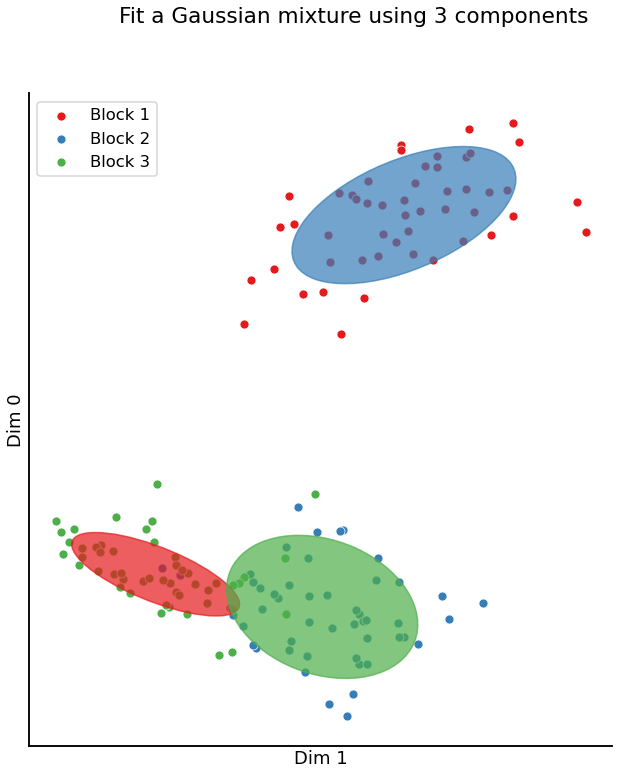

In [17]:
from sklearn.mixture import GaussianMixture
labels = ['Block 1'] * 50 + ['Block 2'] * 50 + ['Block 3'] * 50
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(X[:, :2])
pairplot_with_gmm(X[:,:2], gmm, labels)

In [22]:
colors = sns.color_palette('Set1')

In [16]:
colors[0]

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745)

In [ ]:
palette_map = {"labels": label_palette, "clusters": cluster_palette}
cluster_colors = list(map(cluster_palette.get, np.unique(pred)))
